# Quantum Many-Body Problems and the Transverse Ising Model

**Computational Physics Lecture 8**  
*Date: November 28, 2025*

---

## Lecture Overview (60 minutes)

1. **Introduction to Quantum Many-Body Problems** (10 min)
2. **The Transverse Ising Model** (15 min)
3. **Exact Diagonalization Methods** (15 min)
4. **Phase Transitions and Critical Phenomena** (15 min)
5. **Advanced Topics and Applications** (5 min)

---

## Learning Objectives

By the end of this lecture, you will:
- Understand the challenges of quantum many-body systems
- Learn the transverse Ising model Hamiltonian and its physics
- Implement exact diagonalization for small quantum systems
- Analyze quantum phase transitions
- Visualize quantum correlations and entanglement

## Setup and Imports

First, let's import the necessary libraries for our quantum many-body calculations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import seaborn as sns
from itertools import product

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"SciPy available for sparse matrix operations")

Libraries imported successfully!
NumPy version: 2.2.6
SciPy available for sparse matrix operations


---

# Part 1: Introduction to Quantum Many-Body Problems

## What is a Quantum Many-Body Problem?

A quantum many-body system consists of multiple interacting quantum particles where:
- The Hilbert space dimension grows **exponentially** with system size
- For N spin-1/2 particles: dimension = $2^N$
- Cannot be factorized into independent single-particle problems

### The Exponential Wall

| Number of Spins (N) | Hilbert Space Dimension | Memory for State Vector |
|---------------------|------------------------|-------------------------|
| 10 | 1,024 | ~8 KB |
| 20 | 1,048,576 | ~8 MB |
| 30 | 1,073,741,824 | ~8 GB |
| 40 | 1,099,511,627,776 | ~8 TB |

**Key Challenge**: For N=40 spins, we need terabytes just to store one quantum state!

### Why Study Many-Body Systems?

1. **Fundamental Physics**: Understanding emergent phenomena
   - Superconductivity
   - Quantum magnetism
   - Topological phases
   
2. **Quantum Computing**: Building blocks for quantum algorithms

3. **Materials Science**: Designing new quantum materials

4. **Statistical Mechanics**: Bridge between microscopic and macroscopic physics

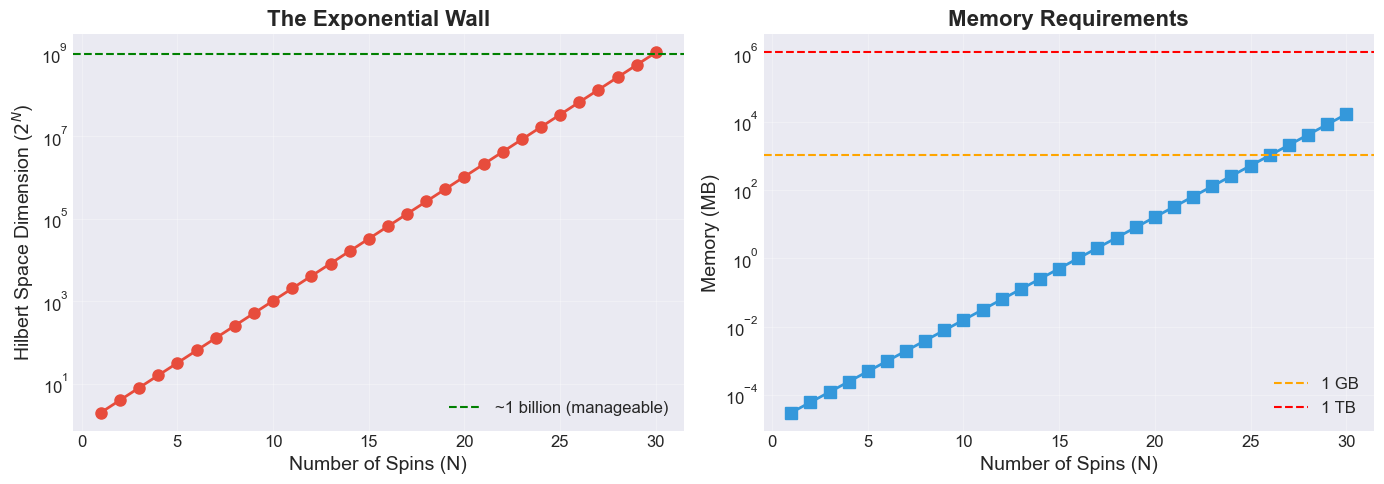

For N=30 spins: Hilbert space dimension = 1,073,741,824
Memory needed: 16.00 GB


In [2]:
# Visualize the exponential growth of Hilbert space
N_values = np.arange(1, 31)
hilbert_dim = 2**N_values
memory_MB = hilbert_dim * 16 / (1024**2)  # 16 bytes per complex number

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hilbert space dimension
ax1.semilogy(N_values, hilbert_dim, 'o-', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Number of Spins (N)', fontsize=14)
ax1.set_ylabel('Hilbert Space Dimension ($2^N$)', fontsize=14)
ax1.set_title('The Exponential Wall', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1e9, color='green', linestyle='--', label='~1 billion (manageable)')
ax1.legend()

# Memory requirement
ax2.semilogy(N_values, memory_MB, 's-', linewidth=2, markersize=8, color='#3498db')
ax2.set_xlabel('Number of Spins (N)', fontsize=14)
ax2.set_ylabel('Memory (MB)', fontsize=14)
ax2.set_title('Memory Requirements', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1024, color='orange', linestyle='--', label='1 GB')
ax2.axhline(y=1024**2, color='red', linestyle='--', label='1 TB')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"For N=30 spins: Hilbert space dimension = {2**30:,}")
print(f"Memory needed: {2**30 * 16 / (1024**3):.2f} GB")

---

# Part 2: The Transverse Ising Model

## Model Definition

The **Transverse Field Ising Model** (TFIM) is one of the simplest yet most important quantum many-body models.

### Hamiltonian

$$\hat{H} = -J \sum_{i=1}^{N-1} \sigma_i^z \sigma_{i+1}^z - h \sum_{i=1}^{N} \sigma_i^x$$

where:
- $J$: Coupling strength between neighboring spins (exchange interaction)
- $h$: Transverse magnetic field strength
- $\sigma^z$, $\sigma^x$: Pauli matrices
- $N$: Number of spins (lattice sites)

### Physical Interpretation

1. **First Term**: $-J \sum_i \sigma_i^z \sigma_{i+1}^z$ 
   - Classical Ising interaction in z-direction
   - Favors alignment of neighboring spins
   - For $J > 0$: ferromagnetic (parallel alignment preferred)

2. **Second Term**: $-h \sum_i \sigma_i^x$
   - Transverse field induces quantum fluctuations
   - Tries to flip spins, creating superposition states

### Pauli Matrices Review

$$\sigma^x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \quad
\sigma^y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \quad
\sigma^z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$

**Key Properties**:
- $[\sigma^i, \sigma^j] = 2i\epsilon_{ijk}\sigma^k$ (commutation relations)
- $[\sigma^x, \sigma^z] = -2i\sigma^y \neq 0$ (non-commuting operators!)
- Eigenvalues: $\pm 1$ (spin up/down)
- $\sigma^z |{\uparrow}\rangle = |{\uparrow}\rangle$, $\sigma^z |{\downarrow}\rangle = -|{\downarrow}\rangle$

In [6]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity_2 = np.eye(2, dtype=complex)

print("Pauli Matrices:")
print("\nσ^x (Sigma X):")
print(sigma_x)
print("\nσ^y (Sigma Y):")
print(sigma_y)
print("\nσ^z (Sigma Z):")
print(sigma_z)

# Verify commutation relations
comm_xz = sigma_x @ sigma_z - sigma_z @ sigma_x
print("\n[σ^x, σ^z] = σ^x σ^z - σ^z σ^x =")
print(comm_xz)
print("\n-2i σ^y =")
print(2j * sigma_y)
print("\nCommutation relation verified:", np.allclose(comm_xz, -2j * sigma_y))

Pauli Matrices:

σ^x (Sigma X):
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

σ^y (Sigma Y):
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]

σ^z (Sigma Z):
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

[σ^x, σ^z] = σ^x σ^z - σ^z σ^x =
[[ 0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j]]

-2i σ^y =
[[ 0.+0.j  2.-0.j]
 [-2.+0.j  0.+0.j]]

Commutation relation verified: True


## Competing Terms: Classical vs Quantum

The TFIM features a **competition** between two terms that don't commute:

### Limiting Cases

1. **$h = 0$ (No transverse field)**:
   - $\hat{H} = -J \sum_i \sigma_i^z \sigma_{i+1}^z$
   - Classical ferromagnetic Ising model
   - Ground state: All spins aligned $|\uparrow\uparrow\uparrow...\rangle$ or $|\downarrow\downarrow\downarrow...\rangle$
   - Two-fold degenerate ground state

2. **$J = 0$ (No coupling, strong field)**:
   - $\hat{H} = -h \sum_i \sigma_i^x$
   - Independent spins in transverse field
   - Ground state: Product state $|\rightarrow\rangle^{\otimes N}$ where $\sigma^x|\rightarrow\rangle = |\rightarrow\rangle$
   - Each spin points in +x direction

3. **$h \ll J$ (Weak field)**:
   - Ferromagnetic phase
   - Spins aligned along z-axis
   - Small quantum fluctuations

4. **$h \gg J$ (Strong field)**:
   - Paramagnetic phase
   - Spins aligned along x-axis
   - Field dominates

### Quantum Phase Transition

At a critical value $h_c \approx J$, the system undergoes a **quantum phase transition** (QPT):
- Transition occurs at **zero temperature**
- Driven by quantum fluctuations (not thermal)
- Ground state changes qualitatively

---

# Part 3: Exact Diagonalization Method

## Building the Hamiltonian Matrix

For a system of $N$ spins, we need to construct the Hamiltonian in the full Hilbert space.

### Tensor Product Structure

For a spin at site $i$, we use the tensor product:

$$\sigma_i^z = \underbrace{\mathbb{I} \otimes \mathbb{I} \otimes \cdots}_{i-1} \otimes \sigma^z \otimes \underbrace{\mathbb{I} \otimes \cdots \otimes \mathbb{I}}_{N-i}$$

### Algorithm Steps

1. **Choose basis**: Computational basis $|s_1, s_2, ..., s_N\rangle$ where $s_i \in \{\uparrow, \downarrow\}$

2. **Build single-site operators**: Use tensor products to create $\sigma_i^x$ and $\sigma_i^z$ for each site

3. **Construct interaction terms**: 
   - $\sigma_i^z \sigma_{i+1}^z$ for nearest-neighbor coupling
   - $\sigma_i^x$ for transverse field

4. **Diagonalize**: Find eigenvalues and eigenvectors
   - Full diagonalization: $O(2^{3N})$ complexity
   - Sparse methods: Only need ground state and low-lying states

### Computational Complexity

- **Memory**: $O(2^{2N})$ for full Hamiltonian matrix
- **Time**: $O(2^{3N})$ for full diagonalization
- **Sparse methods**: Can handle up to N ~ 20-25 spins

In [49]:
def build_transverse_ising_hamiltonian(N, J=1.0, h=0.5, use_sparse=True):
    """
    Build the Hamiltonian for the Transverse Field Ising Model.
    
    Parameters:
    -----------
    N : int
        Number of spins
    J : float
        Coupling strength (ferromagnetic if J > 0)
    h : float
        Transverse field strength
    use_sparse : bool
        Use sparse matrices (recommended for N > 10)
    
    Returns:
    --------
    H : array or sparse matrix
        Hamiltonian matrix (2^N x 2^N)
    """
    
    if use_sparse:
        # Use sparse matrices for efficiency
        from scipy.sparse import csr_matrix, kron, identity
        
        # Define Pauli matrices as sparse
        sx = csr_matrix([[0, 1], [1, 0]], dtype=complex)
        sz = csr_matrix([[1, 0], [0, -1]], dtype=complex)
        eye = csr_matrix(identity(2, dtype=complex))
        
        # Initialize Hamiltonian
        dim = 2**N
        H = csr_matrix((dim, dim), dtype=complex)
        
        # Add nearest-neighbor interaction: -J σ^z_i σ^z_{i+1}
        for i in range(N - 1):
            # Build σ^z_i ⊗ σ^z_{i+1}
            op = sz if i == 0 else eye
            for j in range(1, N):
                if j == i or j == i + 1:
                    op = kron(op, sz, format='csr')
                else:
                    op = kron(op, eye, format='csr')
            H = H - J * op
        
        # Add transverse field: -h σ^x_i
        for i in range(N):
            # Build σ^x_i
            op = sx if i == 0 else eye
            for j in range(1, N):
                if j == i:
                    op = kron(op, sx, format='csr')
                else:
                    op = kron(op, eye, format='csr')
            H = H - h * op
    
    else:
        # Use dense matrices (only for small N)
        sx = np.array([[0, 1], [1, 0]], dtype=complex)
        sz = np.array([[1, 0], [0, -1]], dtype=complex)
        eye = np.eye(2, dtype=complex)
        
        dim = 2**N
        H = np.zeros((dim, dim), dtype=complex)
        
        # Add interactions
        for i in range(N - 1):
            op = sz if i == 0 else eye
            for j in range(1, N):
                if j == i or j == i + 1:
                    op = np.kron(op, sz)
                else:
                    op = np.kron(op, eye)
            H = H - J * op
        
        for i in range(N):
            op = sx if i == 0 else eye
            for j in range(1, N):
                if j == i:
                    op = np.kron(op, sx)
                else:
                    op = np.kron(op, eye)
            H = H - h * op
    
    return H

# Test with a small system (N=4)
N_test = 4
J_test = 1.0
h_test = 0.5

print(f"Building Hamiltonian for N={N_test} spins...")
print(f"Hilbert space dimension: 2^{N_test} = {2**N_test}")
print(f"Parameters: J={J_test}, h={h_test}")

H_test = build_transverse_ising_hamiltonian(N_test, J=J_test, h=h_test, use_sparse=False)

print(f"\nHamiltonian shape: {H_test.shape}")
print(f"Is Hermitian: {np.allclose(H_test, H_test.conj().T)}")
print(f"Is real: {np.allclose(H_test.imag, 0)}")

# Show a small portion of the matrix
print("\nFirst 8x8 block of Hamiltonian:")
print(np.real(H_test[:8, :8]).round(2))

Building Hamiltonian for N=4 spins...
Hilbert space dimension: 2^4 = 16
Parameters: J=1.0, h=0.5

Hamiltonian shape: (16, 16)
Is Hermitian: True
Is real: True

First 8x8 block of Hamiltonian:
[[-3.  -0.5 -0.5  0.  -0.5  0.   0.   0. ]
 [-0.5 -1.   0.  -0.5  0.  -0.5  0.   0. ]
 [-0.5  0.   1.  -0.5  0.   0.  -0.5  0. ]
 [ 0.  -0.5 -0.5 -1.   0.   0.   0.  -0.5]
 [-0.5  0.   0.   0.   1.  -0.5 -0.5  0. ]
 [ 0.  -0.5  0.   0.  -0.5  3.   0.  -0.5]
 [ 0.   0.  -0.5  0.  -0.5  0.   1.  -0.5]
 [ 0.   0.   0.  -0.5  0.  -0.5 -0.5 -1. ]]


E_0 = -9.000000
E_1 = -9.000000
E_2 = -7.000000
E_3 = -7.000000
E_4 = -7.000000
E_5 = -7.000000
E_6 = -7.000000
E_7 = -7.000000
E_8 = -7.000000
E_9 = -7.000000
E_10 = -7.000000
E_11 = -7.000000
E_12 = -7.000000
E_13 = -7.000000
E_14 = -7.000000
E_15 = -7.000000
E_16 = -7.000000
E_17 = -7.000000
E_18 = -7.000000
E_19 = -7.000000
E_20 = -5.000000
E_21 = -5.000000
E_22 = -5.000000
E_23 = -5.000000
E_24 = -5.000000
E_25 = -5.000000
E_26 = -5.000000
E_27 = -5.000000
E_28 = -5.000000
E_29 = -5.000000
E_30 = -5.000000
E_31 = -5.000000
E_32 = -5.000000
E_33 = -5.000000
E_34 = -5.000000
E_35 = -5.000000
E_36 = -5.000000
E_37 = -5.000000
E_38 = -5.000000
E_39 = -5.000000
E_40 = -5.000000
E_41 = -5.000000
E_42 = -5.000000
E_43 = -5.000000
E_44 = -5.000000
E_45 = -5.000000
E_46 = -5.000000
E_47 = -5.000000
E_48 = -5.000000
E_49 = -5.000000
E_50 = -5.000000
E_51 = -5.000000
E_52 = -5.000000
E_53 = -5.000000
E_54 = -5.000000
E_55 = -5.000000
E_56 = -5.000000
E_57 = -5.000000
E_58 = -5.000000
E_59 = 

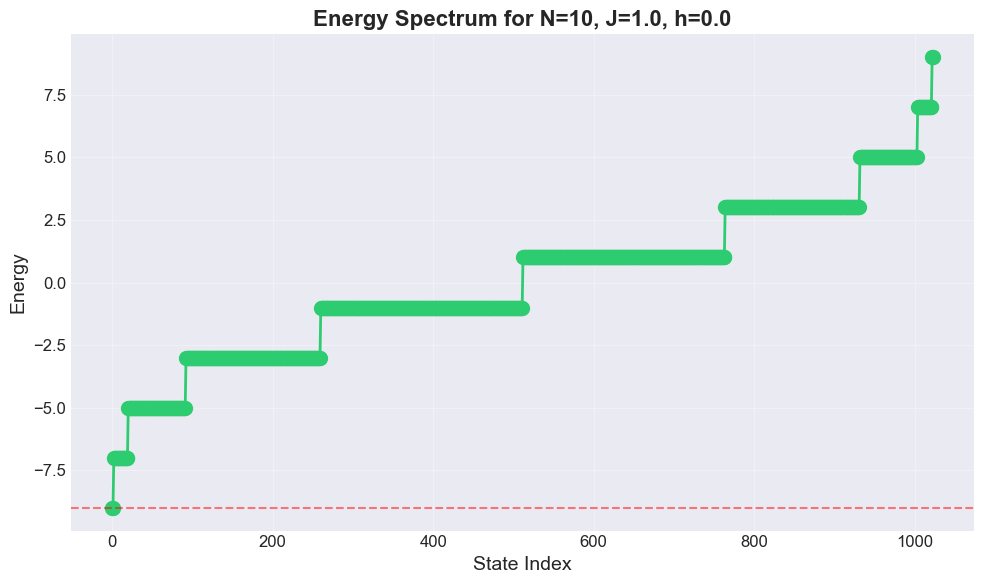

In [50]:
def diagonalize_hamiltonian(H, n_states=5, use_sparse=True):
    """
    Diagonalize the Hamiltonian and return eigenvalues and eigenvectors.
    
    Parameters:
    -----------
    H : array or sparse matrix
        Hamiltonian matrix
    n_states : int
        Number of lowest energy states to compute (for sparse)
    use_sparse : bool
        Use sparse eigensolver
    
    Returns:
    --------
    eigenvalues : array
        Energy eigenvalues (sorted)
    eigenvectors : array
        Corresponding eigenvectors
    """
    
    if use_sparse:
        # Use sparse eigensolver (much faster for large systems)
        from scipy.sparse.linalg import eigsh
        eigenvalues, eigenvectors = eigsh(H, k=n_states, which='SA')
    else:
        # Full diagonalization
        from scipy.linalg import eigh
        eigenvalues, eigenvectors = eigh(H)
        eigenvalues = eigenvalues[:n_states]
        eigenvectors = eigenvectors[:, :n_states]
    
    # Sort by energy
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvalues, eigenvectors

# Test with a small system (N=4)
N_test = 10
J_test = 1.0
h_test = 0.0
n_total = 2**N_test
H_test = build_transverse_ising_hamiltonian(N_test, J=J_test, h=h_test, use_sparse=False)
energies, states = diagonalize_hamiltonian(H_test, n_states=n_total, use_sparse=False)

# Display energy eigenvalues
for i, E in enumerate(energies):
    print(f"E_{i} = {E:.6f}")

print(f"\nGround state energy: E_0 = {energies[0]:.6f}")
print(f"First excited state: E_1 = {energies[1]:.6f}")
print(f"Energy gap: ΔE = {energies[1] - energies[0]:.6f}")

# Visualize energy spectrum
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(energies)), energies, 'o-', markersize=10, linewidth=2, color='#2ecc71')
ax.set_xlabel('State Index', fontsize=14)
ax.set_ylabel('Energy', fontsize=14)
ax.set_title(f'Energy Spectrum for N={N_test}, J={J_test}, h={h_test}', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=energies[0], color='red', linestyle='--', alpha=0.5, label='Ground State')
plt.tight_layout()
plt.show()

---

# Part 4: Quantum Phase Transitions and Critical Phenomena

## Order Parameters

To characterize different phases, we use **order parameters**:

### 1. Magnetization in z-direction

$$M_z = \frac{1}{N} \sum_{i=1}^N \langle \sigma_i^z \rangle$$

- **Ferromagnetic phase** ($h < h_c$): $|M_z| > 0$
- **Paramagnetic phase** ($h > h_c$): $M_z = 0$

### 2. Magnetization in x-direction

$$M_x = \frac{1}{N} \sum_{i=1}^N \langle \sigma_i^x \rangle$$

- **Ferromagnetic phase**: $M_x = 0$
- **Paramagnetic phase**: $M_x > 0$

### 3. Energy Gap

$$\Delta E = E_1 - E_0$$

- Gap closes at critical point: $\Delta E \to 0$ as $N \to \infty$ and $h \to h_c$

### Critical Point

For the 1D transverse Ising model with nearest-neighbor coupling:

$$h_c = J$$

This is exactly solvable! The critical field equals the coupling strength.

In [61]:
def compute_magnetization(state, N, direction='z', use_sparse=None):
    """
    Compute magnetization in a given direction for a quantum state.
    
    Parameters:
    -----------
    state : array
        Quantum state vector (2^N dimensional)
    N : int
        Number of spins
    direction : str
        'x' or 'z' direction
    use_sparse : bool, optional
        Use sparse matrices (auto-detect if None based on system size)
    
    Returns:
    --------
    M : float
        Magnetization per site
    """
    
    # Auto-detect whether to use sparse based on system size
    if use_sparse is None:
        use_sparse = (N > 10)
    
    if use_sparse:
        from scipy.sparse import kron, identity, csr_matrix
        
        if direction == 'z':
            pauli = csr_matrix([[1, 0], [0, -1]], dtype=complex)
        elif direction == 'x':
            pauli = csr_matrix([[0, 1], [1, 0]], dtype=complex)
        else:
            raise ValueError("direction must be 'x' or 'z'")
        eye = csr_matrix(identity(2, dtype=complex))
        
        M_total = 0.0
        
        for i in range(N):
            # Build operator for site i
            op = pauli if i == 0 else eye
            for j in range(1, N):
                if j == i:
                    op = kron(op, pauli, format='csr')
                else:
                    op = kron(op, eye, format='csr')
            
            # Compute expectation value
            expectation = np.real(state.conj() @ op @ state)
            M_total += expectation
    
    else:
        # Use dense matrices
        if direction == 'z':
            pauli = np.array([[1, 0], [0, -1]], dtype=complex)
        elif direction == 'x':
            pauli = np.array([[0, 1], [1, 0]], dtype=complex)
        else:
            raise ValueError("direction must be 'x' or 'z'")
        eye = np.eye(2, dtype=complex)
        
        M_total = 0.0
        
        for i in range(N):
            # Build operator for site i
            op = pauli if i == 0 else eye
            for j in range(1, N):
                if j == i:
                    op = np.kron(op, pauli)
                else:
                    op = np.kron(op, eye)
            
            # Compute expectation value
            expectation = np.real(state.conj() @ op @ state)
            M_total += expectation
    
    return M_total / N
N_test = 4
J_test = 1.0
h_test = 0.0
H_test = build_transverse_ising_hamiltonian(N_test, J=J_test, h=h_test, use_sparse=False)
energies, states = diagonalize_hamiltonian(H_test, n_states=3, use_sparse=False)

# Compute magnetizations for our test system
ground_state = states[:, 0]

Mz = compute_magnetization(ground_state, N_test, 'z')
Mx = compute_magnetization(ground_state, N_test, 'x')

print(f"Ground State Properties (N={N_test}, J={J_test}, h={h_test}):")
print(f"  Magnetization in z: M_z = {Mz:.6f}")
print(f"  Magnetization in x: M_x = {Mx:.6f}")
print(f"  Energy: E_0 = {energies[0]:.6f}")
print(f"  Energy gap: ΔE = {energies[2] - energies[0]:.6f}")

Ground State Properties (N=4, J=1.0, h=0.0):
  Magnetization in z: M_z = 1.000000
  Magnetization in x: M_x = 0.000000
  Energy: E_0 = -3.000000
  Energy gap: ΔE = 2.000000


## Scanning the Phase Transition

Now let's scan across different values of the transverse field $h$ to observe the quantum phase transition.

### Important: Finite-Size Effects

**Critical concept**: For a **finite** system with N spins, the energy gap **never truly closes**!

- In the **thermodynamic limit** ($N \to \infty$): Gap closes exactly at $h_c = J$
- For **finite N**: Gap has a minimum near $h_c$, but remains finite
- **Scaling**: At the critical point, $\Delta E(N, h_c) \sim \frac{1}{N}$

This is why we need finite-size scaling analysis to extract the exact critical point from finite-size data.

Scanning phase transition...
This may take a minute for larger systems...



/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: divide by zero encountered in matmul
  expectation = np.real(state.conj() @ op @ state)
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: overflow encountered in matmul
  expectation = np.real(state.conj() @ op @ state)
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: invalid value encountered in matmul
  expectation = np.real(state.conj() @ op @ state)


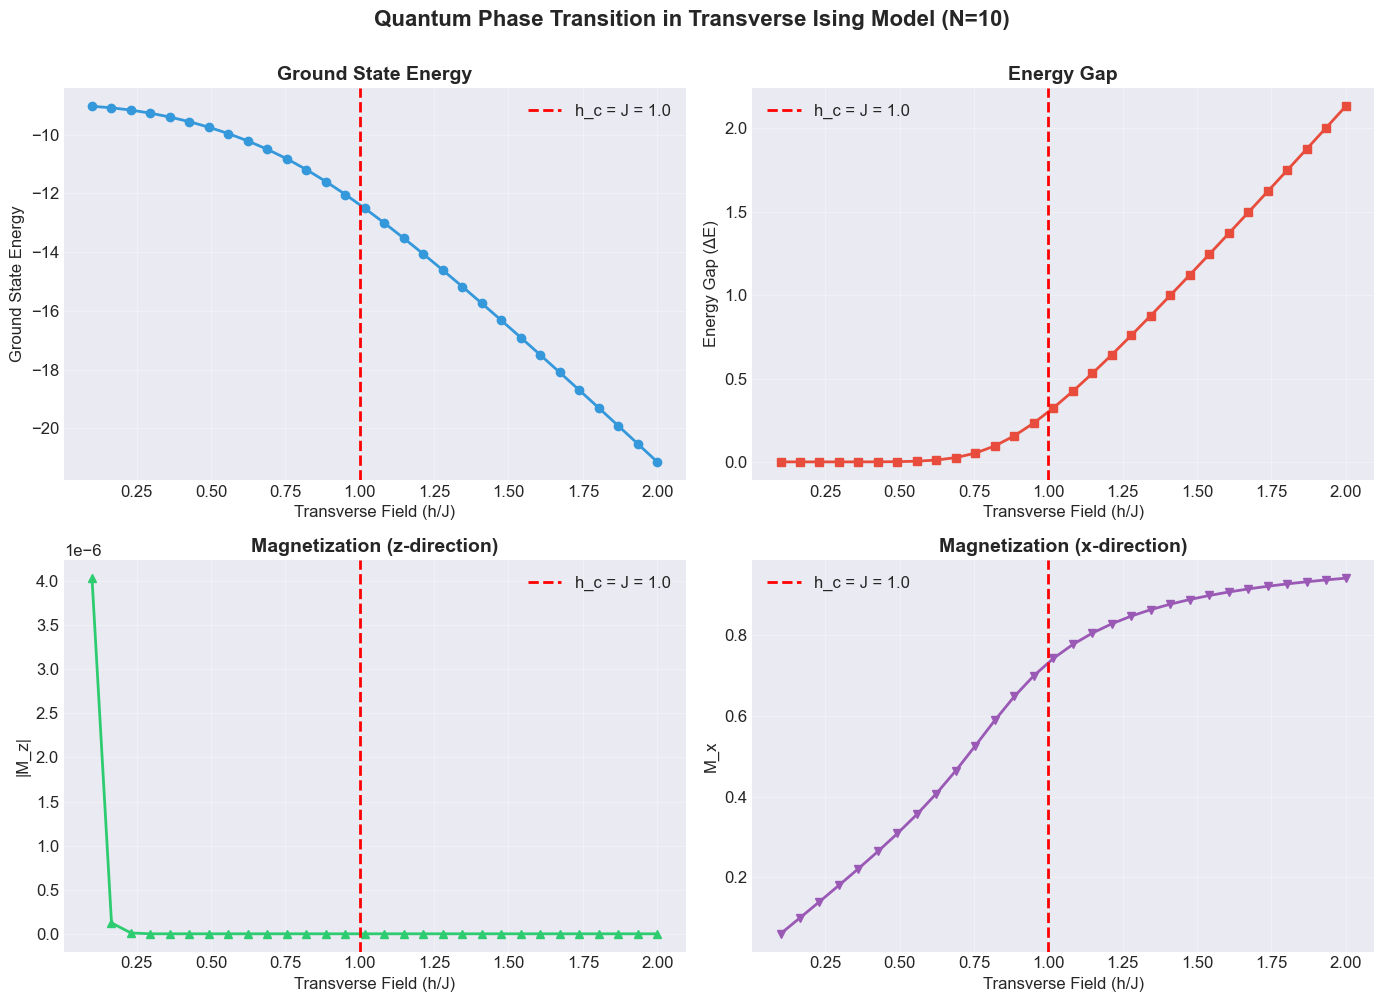


Phase Transition Analysis:
  Critical field (expected): h_c = 1.0
  Minimum gap at h ≈ 0.100
  Minimum gap value: ΔE_min = 0.000000

  Note: For finite N=10, the gap does NOT close!
  The gap at h_c scales as: ΔE(N, h_c) ~ 1/N
  Only in the limit N → ∞ does the gap truly close at h_c


In [37]:
# Scan across the phase transition
print("Scanning phase transition...")
print("This may take a minute for larger systems...\n")

# NOTE: For finite systems, the gap never truly closes!
# The gap minimum approaches h_c = J as N increases
# Gap scales as: Δ(N) ~ 1/N at the critical point
N_scan = 10  # System size
J_fixed = 1.0
h_values = np.linspace(0.1, 2.0, 30)

energies_scan = []
gaps_scan = []
Mz_values = []
Mx_values = []

for h in h_values:
    # Build and diagonalize Hamiltonian
    H = build_transverse_ising_hamiltonian(N_scan, J=J_fixed, h=h, use_sparse=True)
    E, psi = diagonalize_hamiltonian(H, n_states=2, use_sparse=True)
    
    energies_scan.append(E[0])
    gaps_scan.append(E[1] - E[0])
    
    # Compute magnetizations
    ground_state = psi[:, 0]
    Mz = compute_magnetization(ground_state, N_scan, 'z')
    Mx = compute_magnetization(ground_state, N_scan, 'x')
    
    Mz_values.append(abs(Mz))  # Take absolute value
    Mx_values.append(Mx)

# Convert to arrays
energies_scan = np.array(energies_scan)
gaps_scan = np.array(gaps_scan)
Mz_values = np.array(Mz_values)
Mx_values = np.array(Mx_values)

# Plot phase transition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ground state energy
axes[0, 0].plot(h_values, energies_scan, 'o-', linewidth=2, markersize=6, color='#3498db')
axes[0, 0].axvline(x=J_fixed, color='red', linestyle='--', linewidth=2, label=f'h_c = J = {J_fixed}')
axes[0, 0].set_xlabel('Transverse Field (h/J)', fontsize=12)
axes[0, 0].set_ylabel('Ground State Energy', fontsize=12)
axes[0, 0].set_title('Ground State Energy', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Energy gap
axes[0, 1].plot(h_values, gaps_scan, 's-', linewidth=2, markersize=6, color='#e74c3c')
axes[0, 1].axvline(x=J_fixed, color='red', linestyle='--', linewidth=2, label=f'h_c = J = {J_fixed}')
axes[0, 1].set_xlabel('Transverse Field (h/J)', fontsize=12)
axes[0, 1].set_ylabel('Energy Gap (ΔE)', fontsize=12)
axes[0, 1].set_title('Energy Gap', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Magnetization in z-direction
axes[1, 0].plot(h_values, Mz_values, '^-', linewidth=2, markersize=6, color='#2ecc71')
axes[1, 0].axvline(x=J_fixed, color='red', linestyle='--', linewidth=2, label=f'h_c = J = {J_fixed}')
axes[1, 0].set_xlabel('Transverse Field (h/J)', fontsize=12)
axes[1, 0].set_ylabel('|M_z|', fontsize=12)
axes[1, 0].set_title('Magnetization (z-direction)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Magnetization in x-direction
axes[1, 1].plot(h_values, Mx_values, 'v-', linewidth=2, markersize=6, color='#9b59b6')
axes[1, 1].axvline(x=J_fixed, color='red', linestyle='--', linewidth=2, label=f'h_c = J = {J_fixed}')
axes[1, 1].set_xlabel('Transverse Field (h/J)', fontsize=12)
axes[1, 1].set_ylabel('M_x', fontsize=12)
axes[1, 1].set_title('Magnetization (x-direction)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Quantum Phase Transition in Transverse Ising Model (N={N_scan})', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nPhase Transition Analysis:")
print(f"  Critical field (expected): h_c = {J_fixed}")
print(f"  Minimum gap at h ≈ {h_values[np.argmin(gaps_scan)]:.3f}")
print(f"  Minimum gap value: ΔE_min = {gaps_scan.min():.6f}")
print(f"\n  Note: For finite N={N_scan}, the gap does NOT close!")
print(f"  The gap at h_c scales as: ΔE(N, h_c) ~ 1/N")
print(f"  Only in the limit N → ∞ does the gap truly close at h_c")

## Spin-Spin Correlations

Correlation functions reveal how spins are correlated across the lattice:

$$C(r) = \langle \sigma_i^z \sigma_{i+r}^z \rangle - \langle \sigma_i^z \rangle \langle \sigma_{i+r}^z \rangle$$

### Physical Interpretation

- **Ferromagnetic phase** ($h < h_c$): Long-range order, $C(r) \to$ constant as $r \to \infty$
- **Paramagnetic phase** ($h > h_c$): Exponential decay, $C(r) \sim e^{-r/\xi}$
- **Critical point** ($h = h_c$): Power-law decay, $C(r) \sim r^{-\alpha}$

where $\xi$ is the correlation length.

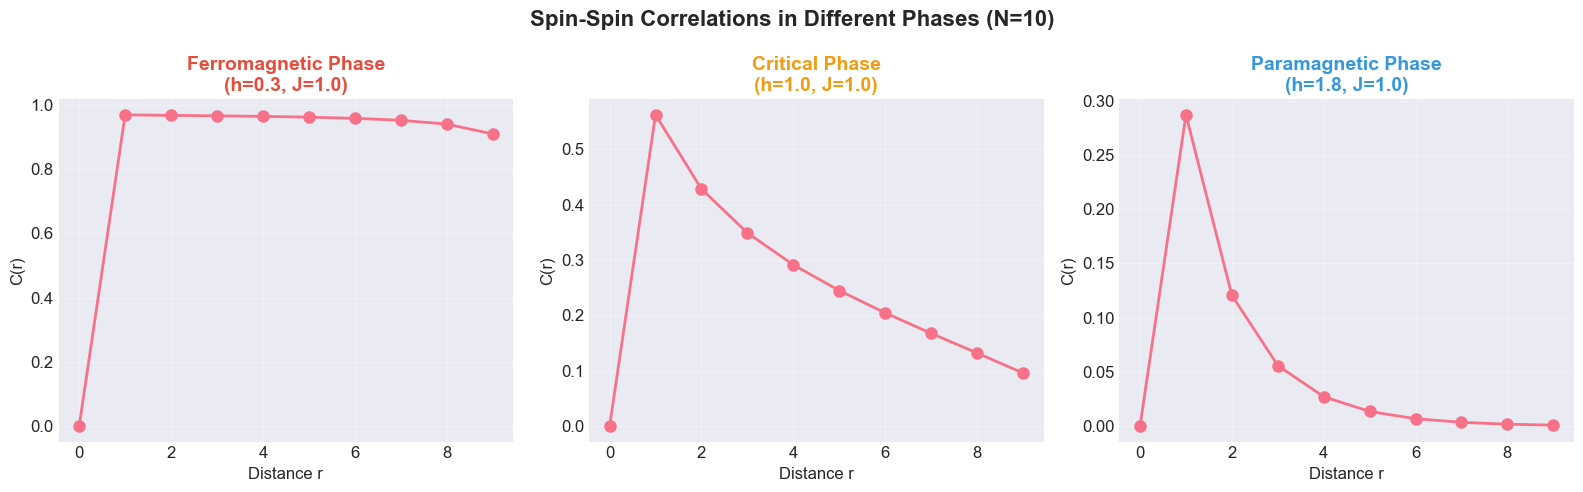


Correlation Behavior:
  Ferromagnetic (h < J): Long-range order, C(r) ≈ constant
  Critical (h ≈ J): Power-law decay
  Paramagnetic (h > J): Exponential decay


In [31]:
def compute_correlation_function(state, N, direction='z'):
    """
    Compute spin-spin correlation function C(r) = <σ_i σ_{i+r}> - <σ_i><σ_{i+r}>
    
    Parameters:
    -----------
    state : array
        Quantum state vector
    N : int
        Number of spins
    direction : str
        'x' or 'z' direction
    
    Returns:
    --------
    correlations : array
        Correlation function C(r) for r = 0, 1, ..., N-1
    """
    
    from scipy.sparse import kron, identity, csr_matrix
    
    if direction == 'z':
        pauli = csr_matrix([[1, 0], [0, -1]], dtype=complex)
    elif direction == 'x':
        pauli = csr_matrix([[0, 1], [1, 0]], dtype=complex)
    else:
        raise ValueError("direction must be 'x' or 'z'")
    
    eye = csr_matrix(identity(2, dtype=complex))
    
    correlations = np.zeros(N)
    
    # Compute single-site expectation values
    single_site_expectations = []
    for i in range(N):
        op = pauli if i == 0 else eye
        for j in range(1, N):
            if j == i:
                op = kron(op, pauli, format='csr')
            else:
                op = kron(op, eye, format='csr')
        exp_val = np.real(state.conj() @ op @ state)
        single_site_expectations.append(exp_val)
    
    # Compute two-site correlation functions
    for r in range(N):
        C_r = 0.0
        count = 0
        
        for i in range(N - r):
            # Build σ_i σ_{i+r}
            if r == 0:
                # σ_i σ_i case
                op = pauli if i == 0 else eye
                for j in range(1, N):
                    if j == i:
                        op = kron(op, pauli, format='csr')
                    else:
                        op = kron(op, eye, format='csr')
            else:
                # σ_i σ_{i+r} case where r > 0
                op = pauli if i == 0 else (pauli if 0 == i + r else eye)
                for j in range(1, N):
                    if j == i or j == i + r:
                        op = kron(op, pauli, format='csr')
                    else:
                        op = kron(op, eye, format='csr')
            
            two_point = np.real(state.conj() @ op @ state)
            disconnected = single_site_expectations[i] * single_site_expectations[i + r]
            
            C_r += (two_point - disconnected)
            count += 1
        
        correlations[r] = C_r / count if count > 0 else 0
    
    return correlations

# Compute correlations for different phases
N_corr = 10
J_corr = 1.0
h_phases = [0.3, 1.0, 1.8]  # Ferromagnetic, Critical, Paramagnetic

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, h in enumerate(h_phases):
    H = build_transverse_ising_hamiltonian(N_corr, J=J_corr, h=h, use_sparse=True)
    E, psi = diagonalize_hamiltonian(H, n_states=1, use_sparse=True)
    ground_state = psi[:, 0]
    
    C_z = compute_correlation_function(ground_state, N_corr, 'z')
    
    axes[idx].plot(range(N_corr), C_z, 'o-', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Distance r', fontsize=12)
    axes[idx].set_ylabel('C(r)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    
    if h < J_corr:
        phase = "Ferromagnetic"
        color = '#e74c3c'
    elif abs(h - J_corr) < 0.1:
        phase = "Critical"
        color = '#f39c12'
    else:
        phase = "Paramagnetic"
        color = '#3498db'
    
    axes[idx].set_title(f'{phase} Phase\n(h={h}, J={J_corr})', 
                       fontsize=14, fontweight='bold', color=color)

plt.suptitle(f'Spin-Spin Correlations in Different Phases (N={N_corr})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Behavior:")
print("  Ferromagnetic (h < J): Long-range order, C(r) ≈ constant")
print("  Critical (h ≈ J): Power-law decay")
print("  Paramagnetic (h > J): Exponential decay")

## Entanglement Entropy

**Entanglement entropy** measures quantum correlations between subsystems.

### Von Neumann Entropy

For a bipartition of the system into regions A and B:

$$S_A = -\text{Tr}(\rho_A \log \rho_A)$$

where $\rho_A = \text{Tr}_B(|\psi\rangle\langle\psi|)$ is the reduced density matrix.

### Area Law vs Volume Law

- **Gapped phases**: $S_A \sim L^{d-1}$ (area law) - boundary of region A
- **Critical point**: $S_A \sim L^{d-1} \log L$ (logarithmic correction)
- **1D at criticality**: $S_A \sim \frac{c}{3} \log L$ where $c$ is central charge

### Physical Meaning

- Quantifies how much quantum information is shared between subsystems
- Maximal at quantum critical points
- Used to classify quantum phases of matter

Computing entanglement entropy...


/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/2514535206.py:28: RuntimeWarning: divide by zero encountered in matmul
  rho_A = state_matrix @ state_matrix.conj().T
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/2514535206.py:28: RuntimeWarning: overflow encountered in matmul
  rho_A = state_matrix @ state_matrix.conj().T
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/2514535206.py:28: RuntimeWarning: invalid value encountered in matmul
  rho_A = state_matrix @ state_matrix.conj().T


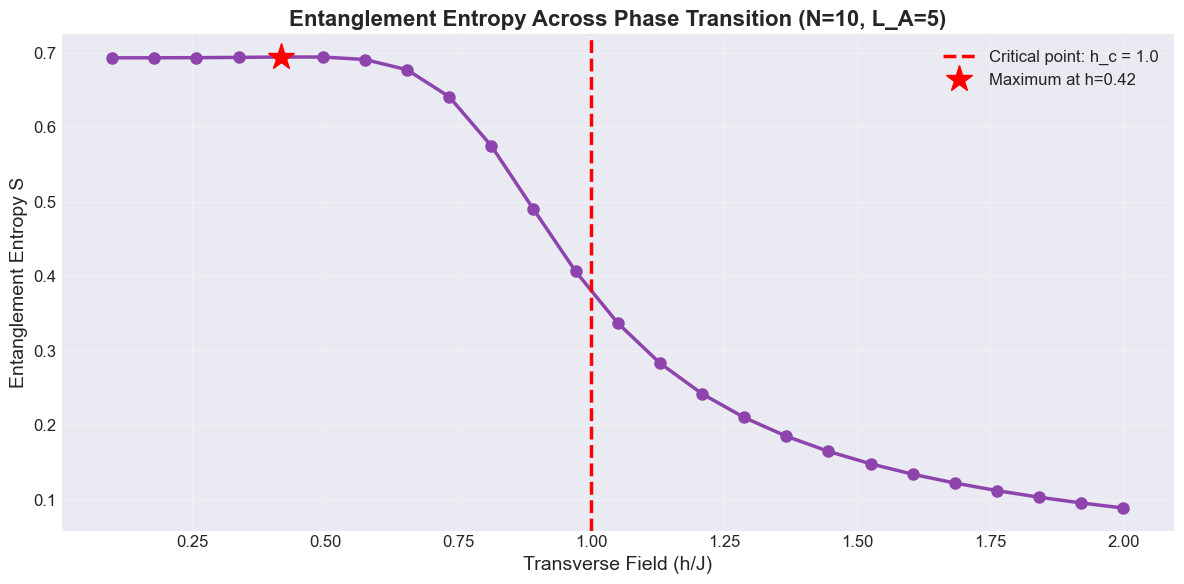


Entanglement Analysis:
  System size: N = 10
  Subsystem size: L_A = 5
  Maximum entropy: S_max = 0.6942 at h = 0.417
  Expected critical field: h_c = 1.0

The entropy is maximal near the critical point!
This indicates maximum entanglement at the quantum phase transition.


In [33]:
def compute_entanglement_entropy(state, N, subsystem_size):
    """
    Compute the entanglement entropy for a bipartition of the system.
    
    Parameters:
    -----------
    state : array
        Quantum state vector (2^N dimensional)
    N : int
        Total number of spins
    subsystem_size : int
        Size of subsystem A (remaining spins form subsystem B)
    
    Returns:
    --------
    S : float
        Von Neumann entanglement entropy
    """
    
    # Reshape state into a matrix for partial trace
    dim_A = 2**subsystem_size
    dim_B = 2**(N - subsystem_size)
    
    # Reshape: state[i*dim_B + j] corresponds to |i>_A ⊗ |j>_B
    state_matrix = state.reshape((dim_A, dim_B))
    
    # Compute reduced density matrix: ρ_A = Tr_B(|ψ><ψ|)
    rho_A = state_matrix @ state_matrix.conj().T
    
    # Diagonalize to get eigenvalues
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Remove numerical zeros and compute entropy
    eigenvalues = eigenvalues[eigenvalues > 1e-12]
    
    S = -np.sum(eigenvalues * np.log(eigenvalues))
    
    return S

# Compute entanglement entropy across the phase transition
print("Computing entanglement entropy...")

N_ent = 10
J_ent = 1.0
h_values_ent = np.linspace(0.1, 2.0, 25)
subsystem_size = N_ent // 2

entropies = []

for h in h_values_ent:
    H = build_transverse_ising_hamiltonian(N_ent, J=J_ent, h=h, use_sparse=True)
    E, psi = diagonalize_hamiltonian(H, n_states=1, use_sparse=True)
    ground_state = psi[:, 0]
    
    S = compute_entanglement_entropy(ground_state, N_ent, subsystem_size)
    entropies.append(S)

entropies = np.array(entropies)

# Plot entanglement entropy
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(h_values_ent, entropies, 'o-', linewidth=2.5, markersize=8, color='#8e44ad')
ax.axvline(x=J_ent, color='red', linestyle='--', linewidth=2.5, 
          label=f'Critical point: h_c = {J_ent}')

ax.set_xlabel('Transverse Field (h/J)', fontsize=14)
ax.set_ylabel('Entanglement Entropy S', fontsize=14)
ax.set_title(f'Entanglement Entropy Across Phase Transition (N={N_ent}, L_A={subsystem_size})', 
            fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Highlight the peak
max_idx = np.argmax(entropies)
ax.plot(h_values_ent[max_idx], entropies[max_idx], 'r*', markersize=20, 
       label=f'Maximum at h={h_values_ent[max_idx]:.2f}')
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nEntanglement Analysis:")
print(f"  System size: N = {N_ent}")
print(f"  Subsystem size: L_A = {subsystem_size}")
print(f"  Maximum entropy: S_max = {entropies[max_idx]:.4f} at h = {h_values_ent[max_idx]:.3f}")
print(f"  Expected critical field: h_c = {J_ent}")
print(f"\nThe entropy is maximal near the critical point!")
print(f"This indicates maximum entanglement at the quantum phase transition.")

## Finite Size Scaling

Real quantum phase transitions occur only in the thermodynamic limit ($N \to \infty$).
For finite systems, we observe **finite-size effects**.

### Key Observations

1. **Energy gap**: $\Delta E(N, h) \to 0$ as $N \to \infty$ only at $h = h_c$

2. **Correlation length**: $\xi(h) \sim |h - h_c|^{-\nu}$ diverges at critical point
   - For TFIM: $\nu = 1$

3. **Finite-size scaling**: Near criticality,
   $$\Delta E(N, h) \sim N^{-z} f\left(N^{1/\nu}(h - h_c)\right)$$
   where $z$ is the dynamic critical exponent

### What We Can Learn

- Extrapolate finite-size data to thermodynamic limit
- Extract critical exponents
- Locate phase transition precisely

Performing finite-size scaling analysis...
Computing for multiple system sizes...

Computing N = 4...
Computing N = 6...


/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: divide by zero encountered in matmul
  expectation = np.real(state.conj() @ op @ state)
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: overflow encountered in matmul
  expectation = np.real(state.conj() @ op @ state)
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/603976146.py:74: RuntimeWarning: invalid value encountered in matmul
  expectation = np.real(state.conj() @ op @ state)


Computing N = 8...
Computing N = 10...
Computing N = 10...
Computing N = 12...
Computing N = 12...


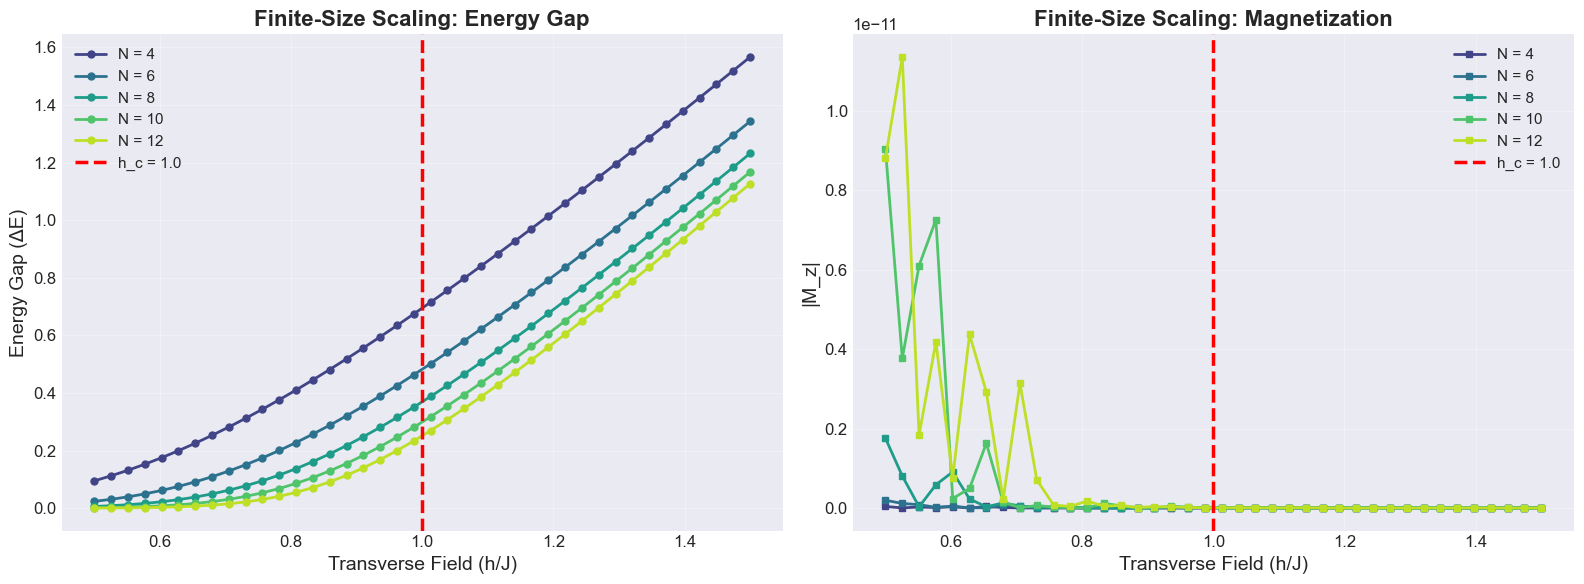


Finite-Size Observations:
  As N increases:
    - Energy gap decreases at h_c
    - Gap → 0 in thermodynamic limit (N → ∞)
    - Magnetization transition becomes sharper
    - All curves cross near h_c = 1.0


In [34]:
# Finite-size scaling analysis
print("Performing finite-size scaling analysis...")
print("Computing for multiple system sizes...\n")

N_sizes = [4, 6, 8, 10, 12]
J_fss = 1.0
h_values_fss = np.linspace(0.5, 1.5, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(N_sizes)))

for idx, N in enumerate(N_sizes):
    print(f"Computing N = {N}...")
    
    gaps_fss = []
    Mz_fss = []
    
    for h in h_values_fss:
        H = build_transverse_ising_hamiltonian(N, J=J_fss, h=h, use_sparse=True)
        E, psi = diagonalize_hamiltonian(H, n_states=2, use_sparse=True)
        
        gap = E[1] - E[0]
        gaps_fss.append(gap)
        
        ground_state = psi[:, 0]
        Mz = abs(compute_magnetization(ground_state, N, 'z'))
        Mz_fss.append(Mz)
    
    gaps_fss = np.array(gaps_fss)
    Mz_fss = np.array(Mz_fss)
    
    # Plot energy gap
    ax1.plot(h_values_fss, gaps_fss, 'o-', linewidth=2, markersize=5, 
            color=colors[idx], label=f'N = {N}')
    
    # Plot magnetization
    ax2.plot(h_values_fss, Mz_fss, 's-', linewidth=2, markersize=5, 
            color=colors[idx], label=f'N = {N}')

# Formatting
ax1.axvline(x=J_fss, color='red', linestyle='--', linewidth=2.5, 
           label=f'h_c = {J_fss}')
ax1.set_xlabel('Transverse Field (h/J)', fontsize=14)
ax1.set_ylabel('Energy Gap (ΔE)', fontsize=14)
ax1.set_title('Finite-Size Scaling: Energy Gap', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.axvline(x=J_fss, color='red', linestyle='--', linewidth=2.5, 
           label=f'h_c = {J_fss}')
ax2.set_xlabel('Transverse Field (h/J)', fontsize=14)
ax2.set_ylabel('|M_z|', fontsize=14)
ax2.set_title('Finite-Size Scaling: Magnetization', fontsize=16, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinite-Size Observations:")
print(f"  As N increases:")
print(f"    - Energy gap decreases at h_c")
print(f"    - Gap → 0 in thermodynamic limit (N → ∞)")
print(f"    - Magnetization transition becomes sharper")
print(f"    - All curves cross near h_c = {J_fss}")

---

# Part 5: Advanced Topics and Extensions

## Beyond Exact Diagonalization

For larger systems (N > 20), exact diagonalization becomes impractical. Alternative methods:

### 1. **Density Matrix Renormalization Group (DMRG)**
- Most powerful method for 1D quantum systems
- Can handle N ~ 100-1000 spins
- Based on matrix product states (MPS)
- Exploits area law of entanglement

### 2. **Quantum Monte Carlo (QMC)**
- Stochastic sampling methods
- Works for certain types of Hamiltonians (no sign problem)
- Can access thermodynamic properties

### 3. **Tensor Network Methods**
- Generalization of DMRG
- Includes PEPS (2D), MERA (holographic)
- Efficient representation of quantum states

### 4. **Mean-Field Theory**
- Approximate method
- Replaces interactions with effective fields
- Good for understanding qualitative physics

## Generalizations of the TFIM

### 1. **Higher Dimensions**
$$\hat{H} = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x$$

where $\langle i,j \rangle$ denotes nearest neighbors on a lattice.

### 2. **Long-Range Interactions**
$$\hat{H} = -\sum_{i<j} \frac{J}{|i-j|^\alpha} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x$$

### 3. **XYZ Model**
$$\hat{H} = -\sum_i \left(J_x \sigma_i^x \sigma_{i+1}^x + J_y \sigma_i^y \sigma_{i+1}^y + J_z \sigma_i^z \sigma_{i+1}^z\right) - h \sum_i \sigma_i^z$$

### 4. **Disorder (Random Field Ising Model)**
$$\hat{H} = -J \sum_i \sigma_i^z \sigma_{i+1}^z - \sum_i h_i \sigma_i^x$$

where $h_i$ are random fields.

## Real-World Applications

### 1. **Quantum Annealing**
- Quantum computers (D-Wave) use transverse Ising model
- Start with large h (paramagnetic phase)
- Slowly reduce h to find ground state
- Used for optimization problems

### 2. **Quantum Magnetism**
- Real materials approximated by spin models
- Example: LiHoF₄ exhibits quantum phase transition
- Controlled by external magnetic field

### 3. **Quantum Information**
- Study of entanglement propagation
- Quantum state transfer
- Topological quantum computing

### 4. **Ultracold Atoms**
- Optical lattices realize spin models
- Direct experimental observation of quantum phase transitions
- Tuneable parameters (J, h)

## Connections to Other Fields

### Statistical Mechanics
- **Classical-Quantum Correspondence**: 
  - d-dimensional quantum system ↔ (d+1)-dimensional classical system
  - Time becomes an extra dimension

### Conformal Field Theory
- Critical points described by CFT
- Universal properties independent of microscopic details
- Central charge characterizes universality class

### Condensed Matter Physics
- Quantum magnetism in real materials
- Superconductivity (BCS theory)
- Topological phases of matter

## Visualizing Quantum States

Let's visualize the ground state wavefunction across the phase transition.

/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/3734684036.py:59: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_28863/3734684036.py:59: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ywchoi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ywchoi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


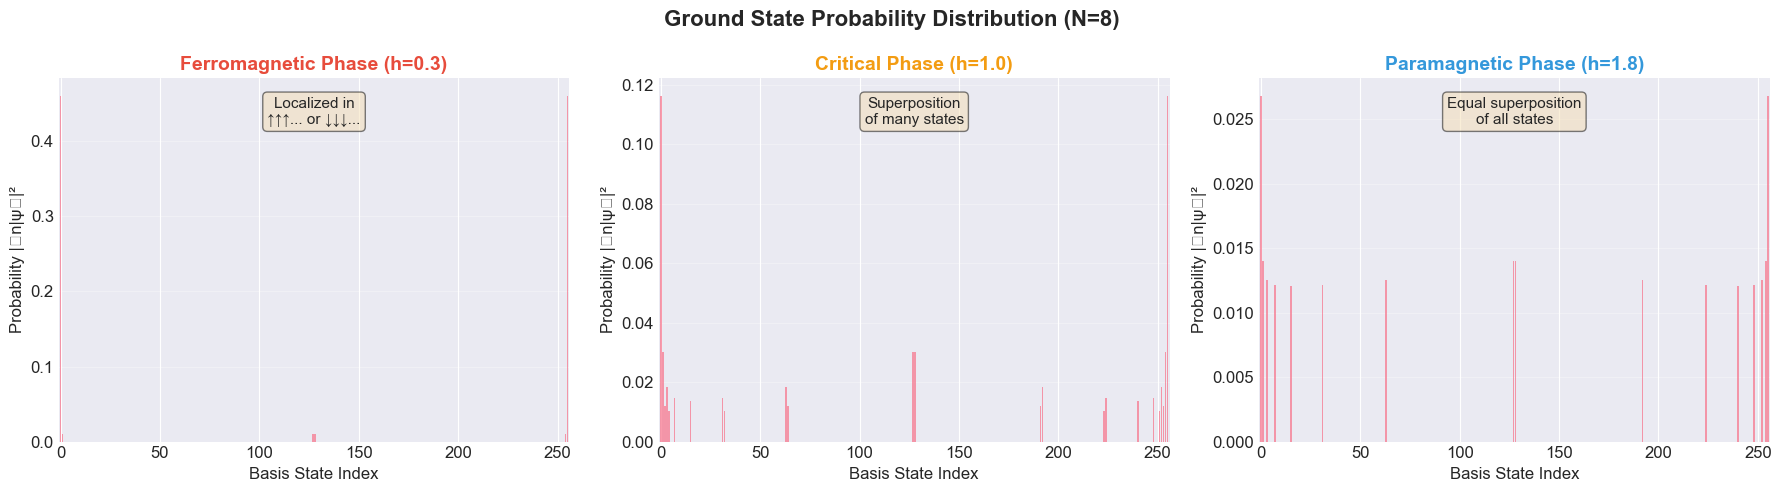


Ground State Characteristics:
  Ferromagnetic: State is localized (peaked at aligned configurations)
  Critical: State has significant weight on many configurations
  Paramagnetic: State is delocalized (spread over all configurations)


In [35]:
# Visualize ground state probability distribution
N_vis = 8
J_vis = 1.0
h_phases_vis = [0.3, 1.0, 1.8]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, h in enumerate(h_phases_vis):
    H = build_transverse_ising_hamiltonian(N_vis, J=J_vis, h=h, use_sparse=True)
    E, psi = diagonalize_hamiltonian(H, n_states=1, use_sparse=True)
    ground_state = psi[:, 0]
    
    # Compute probability distribution
    probabilities = np.abs(ground_state)**2
    
    # Create basis state labels (binary representation)
    basis_states = []
    for i in range(2**N_vis):
        binary = format(i, f'0{N_vis}b')
        # Convert to spin representation
        spin_config = ''.join(['↑' if b == '0' else '↓' for b in binary])
        basis_states.append(spin_config)
    
    # Plot only significant probabilities
    significant = probabilities > 0.01
    x_indices = np.arange(len(probabilities))[significant]
    y_probs = probabilities[significant]
    
    axes[idx].bar(x_indices, y_probs, width=0.8, alpha=0.7)
    axes[idx].set_xlabel('Basis State Index', fontsize=12)
    axes[idx].set_ylabel('Probability |⟨n|ψ⟩|²', fontsize=12)
    axes[idx].set_xlim(-1, 2**N_vis)
    
    if h < J_vis:
        phase = "Ferromagnetic"
        color = '#e74c3c'
        axes[idx].text(0.5, 0.95, 'Localized in\n↑↑↑... or ↓↓↓...', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    elif abs(h - J_vis) < 0.1:
        phase = "Critical"
        color = '#f39c12'
        axes[idx].text(0.5, 0.95, 'Superposition\nof many states', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        phase = "Paramagnetic"
        color = '#3498db'
        axes[idx].text(0.5, 0.95, 'Equal superposition\nof all states', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[idx].set_title(f'{phase} Phase (h={h})', 
                       fontsize=14, fontweight='bold', color=color)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Ground State Probability Distribution (N={N_vis})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nGround State Characteristics:")
print("  Ferromagnetic: State is localized (peaked at aligned configurations)")
print("  Critical: State has significant weight on many configurations")
print("  Paramagnetic: State is delocalized (spread over all configurations)")

---

# Summary

## Key Takeaways

### 1. **Quantum Many-Body Problem**
- Exponential growth of Hilbert space: dim = $2^N$
- Exact diagonalization limited to N ~ 15-20 spins
- Need advanced methods for larger systems

### 2. **Transverse Ising Model**
$$\hat{H} = -J \sum_{i} \sigma_i^z \sigma_{i+1}^z - h \sum_{i} \sigma_i^x$$

- Paradigmatic model for quantum phase transitions
- Competition between classical order and quantum fluctuations
- Exactly solvable in 1D (via Jordan-Wigner transformation)

### 3. **Quantum Phase Transition**
- Occurs at T = 0, driven by quantum fluctuations
- Critical field: $h_c = J$
- **Ferromagnetic phase** (h < J): Aligned spins, $M_z \neq 0$
- **Paramagnetic phase** (h > J): Quantum superposition, $M_x \neq 0$

### 4. **Important Observables**
- **Magnetization**: Order parameter for phases
- **Energy gap**: Closes at critical point (thermodynamic limit)
- **Correlation functions**: Decay from power-law to exponential
- **Entanglement entropy**: Maximal at criticality

### 5. **Computational Methods**
- **Exact Diagonalization**: Limited but exact for small systems
- **DMRG**: State-of-the-art for 1D systems
- **Finite-size scaling**: Extract thermodynamic properties

## Phase Diagram
<pre>
        ↑
        |
   2.0  |  Paramagnetic Phase
        |  (M_x > 0, M_z = 0)
        |
   1.0  |━━━━━━━━━━━━━━━━━━━━ Quantum Critical Point (h_c = J)
        |
        |  Ferromagnetic Phase
   0.0  |  (M_z ≠ 0, M_x = 0)
        └──────────────────────→ J
</pre>

## Broader Context

The transverse Ising model is:
- A **testbed** for quantum many-body methods
- **Realized experimentally** in quantum simulators
- **Related** to many other important models in physics
- A **building block** for understanding more complex phenomena

---

# Exercises

## Exercise 1: Exploring Different Coupling Strengths

Modify the code to study an **antiferromagnetic** Ising model with $J < 0$.

**Tasks**:
1. Set J = -1.0 and repeat the phase transition scan
2. Compare the ground state energy with the ferromagnetic case
3. What is the new critical field $h_c$?
4. How does the magnetization behave differently?

## Exercise 2: Periodic Boundary Conditions

Modify `build_transverse_ising_hamiltonian()` to include periodic boundary conditions.

**Tasks**:
1. Add a term coupling spin N to spin 1: $-J \sigma_N^z \sigma_1^z$
2. Compare energy spectra with open vs periodic boundaries
3. How does this affect the ground state degeneracy?

## Exercise 3: Next-Nearest Neighbor Interactions

Extend the model to include next-nearest neighbor interactions:

$$\hat{H} = -J_1 \sum_i \sigma_i^z \sigma_{i+1}^z - J_2 \sum_i \sigma_i^z \sigma_{i+2}^z - h \sum_i \sigma_i^x$$

**Tasks**:
1. Implement the extended Hamiltonian
2. Study how J₂ affects the phase diagram
3. Compute correlation functions C(1) and C(2)

## Exercise 4: Entanglement Scaling

Investigate how entanglement entropy scales with subsystem size.

**Tasks**:
1. Fix N = 16 and h = h_c
2. Compute S(L_A) for L_A = 1, 2, 3, ..., N/2
3. Plot S vs L_A
4. Does it follow the logarithmic scaling: $S \sim c \log L_A$?
5. Estimate the central charge c

## Exercise 5: Time Evolution (Advanced)

Implement time evolution using the Hamiltonian.

**Tasks**:
1. Start with an initial state (e.g., all spins up)
2. Evolve using: $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$
3. Compute M_z(t) and M_x(t) as functions of time
4. Observe Rabi oscillations between different states

**Hint**: Use `scipy.linalg.expm` to compute the matrix exponential.

## Exercise 6: Critical Exponents

Extract critical exponents from finite-size scaling.

**Tasks**:
1. Compute the gap Δ(N, h=h_c) for various N
2. Fit to $\Delta(N) \sim N^{-z}$ to extract dynamic exponent z
3. Compute magnetization near h_c for various N
4. Fit to scaling form to extract critical exponent β

## Bonus Challenge: Jordan-Wigner Transformation

The TFIM can be mapped to free fermions via Jordan-Wigner transformation:

$$\sigma_i^+ = e^{i\pi \sum_{j<i} c_j^\dagger c_j} c_i, \quad \sigma_i^z = 2c_i^\dagger c_i - 1$$

**Tasks**:
1. Research the Jordan-Wigner transformation
2. Implement the mapping to fermionic operators
3. Diagonalize in the fermionic basis
4. Compare efficiency with direct spin approach
5. Compute exact critical field from the fermionic spectrum

---

# References and Further Reading

## Textbooks

1. **Sachdev, S.** (2011). *Quantum Phase Transitions* (2nd ed.). Cambridge University Press.
   - Comprehensive treatment of QPT, including transverse Ising model
   - Standard reference in the field

2. **Schollwöck, U.** (2011). The density-matrix renormalization group in the age of matrix product states. *Annals of Physics*, 326(1), 96-192.
   - Review of DMRG and tensor network methods

3. **Auerbach, A.** (1994). *Interacting Electrons and Quantum Magnetism*. Springer.
   - Excellent introduction to quantum magnetism

4. **Cardy, J.** (1996). *Scaling and Renormalization in Statistical Physics*. Cambridge University Press.
   - Critical phenomena and conformal field theory

## Review Articles

1. **Pfeuty, P.** (1970). The one-dimensional Ising model with a transverse field. *Annals of Physics*, 57(1), 79-90.
   - Original exact solution of the model

2. **Osborne, T. J., & Nielsen, M. A.** (2002). Entanglement in a simple quantum phase transition. *Physical Review A*, 66(3), 032110.
   - Entanglement entropy at quantum critical points

3. **Amico, L., et al.** (2008). Entanglement in many-body systems. *Reviews of Modern Physics*, 80(2), 517.
   - Comprehensive review of entanglement in many-body physics

## Online Resources

1. **arXiv:1008.3477** - Lecture notes on quantum many-body physics
2. **QuSpin Library**: Python package for exact diagonalization ([quspin.github.io](http://quspin.github.io/QuSpin/))
3. **ITensor**: Efficient tensor network library ([itensor.org](http://itensor.org))
4. **Qiskit**: Quantum computing framework ([qiskit.org](https://qiskit.org))

## Related Topics to Explore

- **Kibble-Zurek mechanism**: Defect formation in quantum quenches
- **Many-body localization**: Breakdown of thermalization
- **Topological phases**: Beyond Landau paradigm
- **Quantum annealing**: Optimization using quantum phase transitions
- **Tensor networks**: Efficient representation of quantum states
- **Conformal field theory**: Universal properties at critical points

---

# Thank You!

## Questions?

Feel free to explore the code, modify parameters, and discover the rich physics of quantum many-body systems!

**Key Message**: The transverse Ising model, despite its simplicity, captures essential features of quantum phase transitions and serves as a gateway to understanding more complex quantum many-body phenomena.

---

*Notebook prepared for Computational Physics 2025*  
*Lecture 8: Quantum Many-Body Problems and Transverse Ising Model*